<a href="https://colab.research.google.com/github/d0lev/API-Security-Detection/blob/main/challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cisco - Ariel University API Security Detection Challenge 2023
### Imports and global settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk import flatten
from urllib.parse import urlparse

In [5]:
# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_path = "/content/drive/MyDrive/CiscoChallenge/Data/dataset_4_train.json";
test_type = ''label'' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(dataset_path) as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# **Preprocessing**

---
At this step we will engineer the various features in the data set,  It involves transforming data to forms that better relate to the underlying target to be learned. 
In the data set, there are various attacks on the API, for this purpose, we will create a binary column that will describe whether or not any attack was carried out in each record

In [6]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

for column in df.columns[df.isna().any()].tolist():
    df[column] = df[column].fillna('None')

# Any entry that contains a particular attack will be labeled malware.
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign': 
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

### **Dataset Description :**

---
Since the following data set is identical in its components compared to the first data set, the explanation of the data set can be found here: [notebook](https://github.com/d0lev/API-Security-Detection/blob/main/challenge_1.ipynb)

### **Classes distribution :**

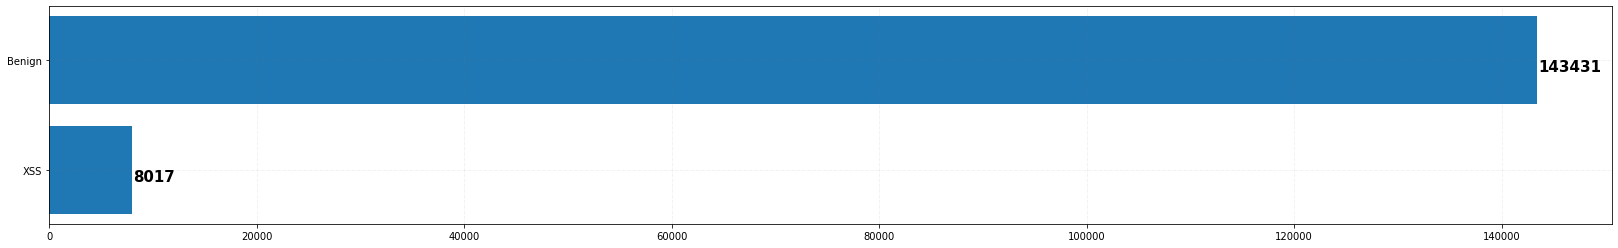

[['Benign' 143431]
 ['XSS' 8017]
 ['SQL Injection' 7924]
 ['Cookie Injection' 7742]
 ['Log Forging' 4037]
 ['RCE' 3944]
 ['Directory Traversal' 3939]
 ['LOG4J' 3733]]


In [7]:
classes_distribution = df['attack_type'].value_counts().to_frame().reset_index().to_numpy()

features = [classes_distribution[0][0],classes_distribution[1][0]]
values = [classes_distribution[0][1] , classes_distribution[1][1]]

fig, ax = plt.subplots(figsize =(28, 4)) 
# Horizontal Bar Plot
ax.barh(features, values)
# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.2)
# Show top values
ax.invert_yaxis()
# Add annotation to bars
counter = 0
for i in ax.patches:
    plt.text(i.get_width() + 100, i.get_y() + 0.5, str(round((i.get_width()), 2)),fontsize = 15, fontweight ='bold', color ='black')

# Show Plot
plt.show()
print(classes_distribution)

As you can see, the data set is not balanced at all, and therefore we will have to use methods that handle this problem.

In [8]:
df.shape

(182767, 30)

### **Feature Enginering :**


In [9]:
#Iterate through the data set and check if there is column that contains one value
from collections import Counter
def non_unique_features(dataframe):
  same_value_features = []
  for column in dataframe.columns:
    if len(Counter(dataframe[column])) == 1:
        same_value_features.append(column)
  return same_value_features

In [10]:
non_unique_features(df)

['request.headers.Host',
 'request.headers.Accept',
 'request.headers.Connection']

In [20]:
dataset = df.drop(non_unique_features(df), axis = 1)
dataset.head(2)

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",?0,de-CH,none,same-origin,no-store,?1,document,['ck=FJRAiycx_3ekqPVGrPhoLGnQ_MKj1ittQ-MCq2zXC...,"Sun, 18 Dec 2022 01:27:48 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...,,302 FOUND,text/html; charset=utf-8,199,/forum,302,text/html; charset=utf-8,None,None,None,None,None,XSS,Malware
1,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['cid=y03gw4TI3ch-xC1BinML6NAIN0DQNEwmnuyTkVoL...,"Sun, 18 Dec 2022 01:36:14 GMT",GET,http://127.0.0.1:5000/greet/Capito,,200 OK,text/html; charset=utf-8,22,None,200,text/html; charset=utf-8,"""Windows""",None,None,None,None,Benign,Benign


The `request.headers.Cookie` , contains more than 39 unique values which represent stored HTTP cookies associated with the server, Therefore,I thought of splitting the feature into three features: the first user's name, the second user's name, and the number of users.

---


In [22]:
def cookie_parsing(dataframe):
  cookies = dataframe['request.headers.Cookie'].tolist()
  columns = ['user1','user2',"n_users"]
  cookie_dataset = []

  for cookie in cookies:
    if cookie == "None":
      cookie_dataset.append([0,0,0])
    else:
      cookie = cookie.replace("username=","")
      cookie_p = cookie.split(";")
      if len(cookie_p) == 2:
        cookie_p.append(2)
        cookie_dataset.append(cookie_p)
      else:
        cookie_p.append(0)
        cookie_p.append(1)
        cookie_dataset.append(cookie_p)

  cookie_dataset = pd.DataFrame(cookie_dataset, columns = columns,dtype = str) 
  cookie_dataset['n_users'] = pd.to_numeric(cookie_dataset['n_users'])

  return cookie_dataset

The `request.url` is an address that contains the information needed to access the server resources.I thought about taking the same address and splitting it according to its different characteristics by a library called urlparse, each address will be represented by the following four attributes:
the scheme, netloc, path, params, query, and fragment.
After this conversion was done, we noticed that the attributes params and fragments contain only values for each address, so we preferred to delete them.

---



In [23]:
def url_parsing(dataframe):
  urls = dataframe['request.url'].tolist()
  columns = ["scheme","netloc","path","params","query","fragment"]
  url_dataset = []

  for url in urls:
    parsed_url = []
    url_p = urlparse(url)
    for index in range(len(url_p)):
        parsed_url.append(url_p[index])
    
    flattened_list = flatten(parsed_url)
    url_dataset.append(flattened_list)

  url_dataset = pd.DataFrame(url_dataset, columns = columns,dtype = str) 
  url_dataset.drop(['params','fragment'],axis = 1,inplace = True)

  return url_dataset

This function used to arrange the data set in such a way that if one column splits into several columns - it takes care of uniting them back into one data set.

---


In [24]:
def dataset_arrange(dataframe , embeddings ,index):
  first_n_column  = dataframe.iloc[: , : index]
  second_n_column = dataframe.iloc[: ,index + 1:]
  first_n_column = first_n_column.join(embeddings)
  dataframe = first_n_column.join(second_n_column)

  return dataframe

The `response.headers.Content-Length` feature contains multiple string that represents the length of the content that send from the host, therfore we will convert them to numeric values.

Also, we will convert the `response.status_code` feature which contains the code that represents the host's successful or unsuccessful response.

---


In [25]:
def numeric_transform(dataframe):
  columns = ['response.headers.Content-Length','response.status_code']
  for col_name in columns:
      dataframe[col_name] = pd.to_numeric(dataframe[col_name])
  return dataframe

There are some features that contain in their content two different types of information, one with a URL address and the other without. We will try to turn these columns into numeric values by setting 1 for a record that contains a URL in the same feature, and 0 otherwise.

---



In [26]:
def contain_url(dataframe):
  columns = ['request.headers.Accept-Encoding','request.headers.Sec-Fetch-Dest','request.headers.Sec-Fetch-Site']
  for col_name in columns:
      dataframe[col_name] = np.where(dataframe[col_name].str.contains("jndi"), 1, 0)

  return dataframe

### **Dealing with missing values :**


In [27]:
means = dataset.isnull().mean()
percentages = means[means > 0].round(4).mul(100).sort_values(ascending=False)
percentages

Series([], dtype: float64)

### **Dealing with categorical features**

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import xgboost as xgb

In [29]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                  'request.headers.Sec-Fetch-Dest',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-User',
                'request.headers.Sec-Ch-Ua-Platform',
                'request.headers.Sec-Ch-Ua-Mobile',
                'request.headers.Cache-Control',
                'request.headers.Upgrade-Insecure-Requests',
                'response.headers.Location'
                ,'request.headers.Content-Length'
                ,'response.headers.Set-Cookie'
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'user1','user2','scheme','netloc','path','query',
                    'request.headers.Set-Cookie',
                    'response.body',
                    'response.headers.Content-Type',
                    ]

COLUMNS_TO_REMOVE = ['request.headers.Date','request.body','response.status','request.method','n_users']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    cookies = cookie_parsing(df)
    urls = url_parsing(df)
    df = dataset_arrange(df , cookies ,df.columns.get_loc("request.headers.Cookie"))
    df = dataset_arrange(df , urls ,df.columns.get_loc("request.url"))
    df = contain_url(df) ## create a column that represent indicator for url in the accept encoding
    df = numeric_transform(df)
    # df = one_hot_content_type(df)

    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=2)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

In [30]:
dataset = vectorize_df(dataset)

In [ ]:
dataset.info(memory_usage="deep")

In [ ]:
dataset.head(1)

In [33]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
def feature_selection (dataframe):

  X = dataframe.drop(['label','attack_type'],axis=1)
  print('x is:', X.columns.to_list())
  columns = X.columns
  X = np.nan_to_num(X)
  #y = dataframe['label']
  y = dataframe['attack_type']
  X = (X-X.min())/(X.max()-X.min())

  # k tells k top features to be selected
  # Score function Chi2 tells the feature to be selected using Chi Square
  test = SelectKBest(score_func=chi2, k = 18)
  fit = test.fit(X, y)

  delete_features = pd.DataFrame({'columns': columns, 'Kept': test.get_support()})
  print(delete_features)
  delete_features = delete_features[(delete_features['Kept'] == False)]['columns'].to_list()

  return delete_features

In [34]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

def feature_selection__2 (dataframe):
  X = dataframe.drop(['label','attack_type'],axis=1)
  print('x is:', X.columns.to_list())
  columns = X.columns
  X = np.nan_to_num(X)
  y = dataframe['label']
  #y = dataframe['attack_type']
  X = (X-X.min())/(X.max()-X.min())

  min_features_to_select = 1  # Minimum number of features to consider
  clf = RandomForestClassifier()
  cv = StratifiedKFold(5)

  rfecv = RFECV(
      estimator=clf,
      step=1,
      cv=cv,
      scoring="accuracy", #targeting on high recall
      min_features_to_select=min_features_to_select,
      n_jobs=2,

  )
  rfecv.fit(X, y)

  delete_features = pd.DataFrame({'columns': columns, 'Kept': rfecv.get_support()})
  delete_features = delete_features[(delete_features['Kept'] == False)]['columns'].to_list()
  print(delete_features)

  return delete_features

In [ ]:
delete_features = feature_selection(dataset)
dataset = dataset.drop(delete_features ,axis = 1)

In [35]:
dataset['label'] = df['label']
dataset['label'] = dataset['label'].map({'Benign': 0, 'Malware': 1})

dataset['attack_type'] = df['attack_type']
dataset['attack_type'] = dataset['attack_type'].map({'Benign': 0, 'Cookie Injection': 1, 'Directory Traversal': 2, 'LOG4J': 3, 'Log Forging': 4, 'RCE': 5, 'SQL Injection': 6, 'XSS': 7})

In [37]:
dataset.head(1)

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,scheme,netloc,path,query,response.headers.Content-Type,response.headers.Content-Length,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,user1,user2,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,0.894427,1,0,2,1,1,3,0,1,0.83205,1.0,0.0,0.0,0.986394,-1.0,199,1,302,-1.0,1,29,0.0,0.0,0,1,7,1


In [ ]:
dataset['label'].value_counts()

In [ ]:
dataset['attack_type'].value_counts()

In [ ]:
matrix = dataset.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [ ]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
dataset.info(memory_usage="deep")

In [ ]:
features_list = dataset.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')

print(features_list)
print(len(features_list))
# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
dataset.dtypes

### **Dealing with imbalanced dataset**

---



In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor

# Load the data
X = dataset[features_list]
#y = dataset['label']
y = np.stack(dataset['attack_type'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Use undersampling to balance the training data
smote = SMOTE(random_state=42)
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)

# Create the base models
model_1 = RandomForestClassifier(random_state=42)
model_2 = GradientBoostingClassifier(random_state=42)
model_3 = SVC(random_state=42)

clf = xgb.XGBClassifier(base_estimator=[model_1, model_2, model_3] , learning_rate = 0.2,max_depth = 5,subsample = 0.6,reg_lambda=1.5, reg_alpha=0.5 , scale_pos_weight = 15)
clf.fit(X_train, y_train)


In [53]:
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
clf_report = classification_report(true_labels, predictions, digits=5)

print(clf_report)

              precision    recall  f1-score   support

           0    0.98816   1.00000   0.99405     21535
           1    1.00000   1.00000   1.00000      1153
           2    0.99829   0.99829   0.99829       585
           3    0.98566   0.52083   0.68154       528
           4    1.00000   0.99188   0.99593       616
           5    1.00000   0.99827   0.99913       578
           6    1.00000   0.99751   0.99875      1204
           7    1.00000   1.00000   1.00000      1217

    accuracy                        0.99041     27416
   macro avg    0.99651   0.93835   0.95846     27416
weighted avg    0.99039   0.99041   0.98899     27416



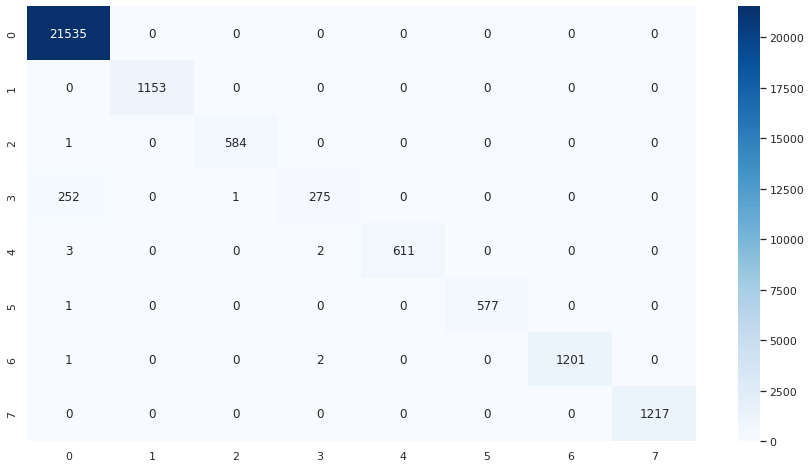

In [52]:
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# Test

In [55]:
with open("/content/drive/MyDrive/CiscoChallenge/Data/dataset_4_val.json") as file:
    raw_ds = json.load(file)

test_df = pd.json_normalize(raw_ds, max_level=2)

for column in test_df.columns[test_df.isna().any()].tolist():
    test_df[column] = test_df[column].fillna('None')

test_df = test_df.drop(non_unique_features(df), axis = 1)
test_df = vectorize_df(test_df)
# test_df = test_df.drop(delete_features,axis = 1)

In [56]:
X = test_df[features_list]
predictions = clf.predict(X)

In [57]:
malware = 0
benign = 0
for p in predictions:
  if p == 1:
     malware = malware + 1
  else:
     benign = benign + 1

In [59]:
print(malware)
print(benign)

1368
30885


# Save your predictions

In [62]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'/content/drive/MyDrive/CiscoChallenge/dataset_4_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')